##                   PRICE: Machine learning pour le trading algorithmique

18/05/2022

By Mbaye DIONGUE

This document contains the code used to train the deep neural network used to predict the 'quality' of a detected divergence. This quality can be seen as the drop or the climb height after the detection of a divergence. As the result, it enables to predict how much and when we should invest ('take profit' in technical term) or withdraw a prior investment ('stop lost').

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras # on peut aussi ne pas l'impoter et utiliser: tf.keras
from keras.layers import Dense, Input, Flatten, Dense, Concatenate, LSTM, Dropout
from keras.models import Model, Sequential
from pandas import read_csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.callbacks import EarlyStopping
from numpy.random import seed
from sklearn.metrics import mean_squared_error 
import math

In [2]:
# to be modified (the repository should be the one hosting the data)
%cd "C:\folder_where_the_data_is_loacated"

C:\Espace étude\EMSE 2A\PRICE\algorithmic_trading-main\algorithmic_trading-main\Trading_project\algo_parallele


### 1. Loading data

In [3]:
with open("dataTot.out", 'r') as file:
    data_= file.readlines()
    
data= np.loadtxt(data_, delimiter=',')
print(data.shape)
data=pd.DataFrame(data)
data.dropna(inplace=True) 
print(data.shape)
data=np.array(data)
#print(data)
#data=np.unique(data, axis=0)
X, Y= np.delete(data, 5, axis=1), data[:,5]

(227494, 66)
(226896, 66)


In [4]:
Y=Y.reshape(-1, 1)
print(X.shape)
print(Y.shape)

(226896, 65)
(226896, 1)


### 2. Splitting data into training, test and validation set

In [5]:
seed(1234) # Pour la reproductibilité
train_size=0.8 # size of the training set
(X_train, X_rem, Y_train, Y_rem) = train_test_split(X, Y, train_size=train_size, random_state=None)

# Validation and test set
test_size=0.5 # test set size in the remaining data
(X_test, X_val, Y_test, Y_val) = train_test_split(X_rem, Y_rem, test_size=test_size, random_state=None)

### 3. Normalization of the data

In [6]:
# Inputs
scalerX = StandardScaler().fit(X_train)
X_train = scalerX.transform(X_train)
X_val = scalerX.transform(X_val)
X_test = scalerX.transform(X_test)

# Outputs
scalerY = StandardScaler().fit(Y_train)
Y_train_ori=Y_train.copy()
Y_train = scalerY.transform(Y_train)
#Y_val = scalerY.transform(Y_val)
#Y_test = scalerY.transform(Y_test)

### 4. Pretreament for the lstm network entry and the first dense network entry

In [7]:
X_train_lstm_temp, X_train2= X_train[:,5:], X_train[:, 0:5]
X_val_lstm_temp, X_val2= X_val[:,5:], X_val[:, 0:5]
X_test_lstm_temp, X_test2= X_test[:,5:], X_test[:, 0:5]

X_train_lstm= np.empty((X_train_lstm_temp.shape[0], X_train_lstm_temp.shape[1]//2, 2))
X_train_lstm[:,:,0]=X_train_lstm_temp[:,0:X_train_lstm_temp.shape[1]//2]
X_train_lstm[:,:,1]=X_train_lstm_temp[:,X_train_lstm_temp.shape[1]//2 :]

X_val_lstm= np.empty((X_val_lstm_temp.shape[0], X_val_lstm_temp.shape[1]//2, 2))
X_val_lstm[:,:,0]=X_val_lstm_temp[:,0:X_val_lstm_temp.shape[1]//2]
X_val_lstm[:,:,1]=X_val_lstm_temp[:,X_val_lstm_temp.shape[1]//2 :]

X_test_lstm= np.empty((X_test_lstm_temp.shape[0], X_test_lstm_temp.shape[1]//2, 2))
X_test_lstm[:,:,0]=X_test_lstm_temp[:,0:X_test_lstm_temp.shape[1]//2]
X_test_lstm[:,:,1]=X_test_lstm_temp[:,X_test_lstm_temp.shape[1]//2 :]

#X_train_lstm=np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1]//2, 2 ))
print("X_train_lstm shape: ", X_train_lstm.shape)
print("X_validattion_lstm shape: ", X_val_lstm.shape)
print("X_test_lstm shape: ", X_test_lstm.shape)

print("X_train2 shape: ", X_train2.shape)
print("Y_train shape: ", Y_train.shape)

X_train_lstm shape:  (181516, 30, 2)
X_validattion_lstm shape:  (22690, 30, 2)
X_test_lstm shape:  (22690, 30, 2)
X_train2 shape:  (181516, 5)
Y_train shape:  (181516, 1)


## 5. LSTM combined with fully-connected layers 
This model combined an LSTM part (fo temporal data) and a classic network part (for other variables: slops of the stock market and the RSI, duration pf the divergence ...). Theses to subnetwork are combined at the end by a fully connected layer that predicts the Y value.

In [8]:
nbVar=5 # number of other variables distinct from the RSI and Cours
context_lenght=30

# feature extraction from temporal data (cours+rsi)
#        X_train_lstm.shape[1]= time_step
temporal_series_input = Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), name='temporal_input')
lstm1=LSTM(8, return_sequences = True)(temporal_series_input)
dropout1 = Dropout(0.3)(lstm1, training=True)
lstm2=LSTM(8, return_sequences = True)(dropout1)
dropout2 = Dropout(0.3)(lstm2, training=True)
dense1_1=Dense( 8,activation = 'relu'  )(dropout2)
#lstm3=LSTM(8, activation = 'relu')(dropout2)
flat_1 = Flatten()(dense1_1)

# feature extraction from other variables ('angle1', 'angle2', 'longueur', 'type divergence')
other_inputs  = Input(shape=(X_train2.shape[1],), name='other_variables')
dense2_1=Dense( 8,activation = 'relu'  )(other_inputs)
dropout2_1 = Dropout(0.3)(dense2_1, training=True)
dense2_2=Dense( 4,activation = 'relu'  )(dropout2_1)
#dropout2_2 = Dropout(0.3)(dense2_2, training=True)
#dense2_3=Dense( 8,activation = 'relu'  )(dropout2_2)
flat_2 = Flatten()(dense2_2)

# concatenate both feature layers and define output layer after some dense layers
concat = Concatenate()([flat_1,flat_2])
dense1 = Dense(8, activation = 'relu')(concat)
dense2 = Dense(8, activation = 'relu')(dense1)
output = Dense(1)(dense2)
#output = Dense(10, activation = 'softmax')(dense3)

# create model with two inputs
model_lstm_dense= Model(inputs=[temporal_series_input, other_inputs], outputs=output)
model_lstm_dense.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 temporal_input (InputLayer)    [(None, 30, 2)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 30, 8)        352         ['temporal_input[0][0]']         
                                                                                                  
 dropout (Dropout)              (None, 30, 8)        0           ['lstm[0][0]']                   
                                                                                                  
 other_variables (InputLayer)   [(None, 5)]          0           []                               
                                                                                              

### 

In [177]:
#tf.random.set_see
step=100
initial_learning_rate=1e-3
step=tf.Variable(0, trainable=False)
print(step)
#tf.compat.v1.train.exponential_decay(starter_learning_rate,global_step, 100000, 0.96, staircase=True)
learning_rate = tf.compat.v1.train.exponential_decay(initial_learning_rate, step, 1000, 0.999, staircase=True)
opt = tf.keras.optimizers.Adam(learning_rate)
model_lstm_dense.compile(loss='mean_squared_error', optimizer=opt)
# to avoid overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True) 

history = model_lstm_dense.fit( [X_train_lstm, X_train2],
                    Y_train,
                    epochs          = 500,
                    batch_size      = batch_size,
                    verbose         = 1,
                    validation_data = ([X_val_lstm, X_val2], Y_val),
                    callbacks=[es, cp_callback]
                   )

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0>
Epoch 1/50
15/15 [==============================] - 5s 87ms/step - loss: 0.9697 - val_loss: 30.8517
Epoch 2/50
15/15 [==============================] - 1s 38ms/step - loss: 0.9688 - val_loss: 30.6902
Epoch 3/50
15/15 [==============================] - 1s 38ms/step - loss: 0.9722 - val_loss: 30.7851
Epoch 4/50
15/15 [==============================] - 1s 39ms/step - loss: 0.9571 - val_loss: 30.7814
Epoch 5/50
15/15 [==============================] - 1s 40ms/step - loss: 0.9639 - val_loss: 30.8431
Epoch 6/50
15/15 [==============================] - 1s 39ms/step - loss: 0.9571 - val_loss: 30.5488
Epoch 7/50
15/15 [==============================] - 1s 38ms/step - loss: 0.9518 - val_loss: 30.8965
Epoch 8/50
15/15 [==============================] - 1s 40ms/step - loss: 0.9576 - val_loss: 30.7402
Epoch 9/50
15/15 [==============================] - 1s 38ms/step - loss: 0.9580 - val_loss: 30.8164
Epoch 10/50
15/15 [========================

plt.plot(history.history['mse'] )
plt.plot(history.history['val_mse'])

### 6. Testing with validation set and training set for parameters optimization

In [ ]:
# On fait les prédictions
# .... Sur les données d'apprentissage
Y_train_predict = model.predict([X_train_lstm, X_train2])  # hauteur de chute prédite sur les données d'apprentissage
Y_train_predict= scalerY.inverse_transform(Y_train_predict) # repassage à l'échelle
#trainY_ = scaler.inverse_transform([trainY])

# ... Sur la validation set 
Y_val_predict = model.predict([X_val_lstm, X_val2])
Y_val_predict = scaler.inverse_transform(Y_val_predict)
#testY_= scaler.inverse_transform([testY])

# Compute root mean squared error
trainScore = math.sqrt(mean_squared_error(Y_train_ori[0], Y_train_predict[:,0]))
print('Train Score: %.5f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(Y_val[0], Y_val_predict[:,0]))
print('Test Score: %.5f RMSE' % (valScore))

### 7. Test set

In [ ]:
# ... Sur les données de  test 
Y_test_predict = model.predict([X_test_lstm, X_test2])
Y_test_predict = scaler.inverse_transform(Y_test_predict)
#testY_= scaler.inverse_transform([testY])

# Compute root mean squared error
testScore = math.sqrt(mean_squared_error(Y_test[0], Y_test_predict[:,0]))
print('Test Score: %.5f RMSE' % (testScore))

In [20]:

# feature extraction from temporal data (cours+rsi)
#        X_train_lstm.shape[1]= time_step
temporal_series_input = Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), name='temporal_input')
lstm1=LSTM(32, return_sequences = True)(temporal_series_input)
dropout1 = Dropout(0.3)(lstm1, training=True)
lstm2=LSTM(16, return_sequences = True)(dropout1)
dropout2 = Dropout(0.3)(lstm2, training=True)
dense1_1=Dense( 8,activation = 'relu'  )(dropout2)
#lstm3=LSTM(8, activation = 'relu')(dropout2)
flat_1 = Flatten()(dense1_1)

# feature extraction from other variables ('angle1', 'angle2', 'longueur', 'type divergence')
other_inputs  = Input(shape=(X_train2.shape[1],), name='other_variables')
dense2_1=Dense( 16,activation = 'relu'  )(other_inputs)
dropout2_1 = Dropout(0.3)(dense2_1, training=True)
dense2_2=Dense( 8,activation = 'relu'  )(dropout2_1)
#dropout2_2 = Dropout(0.3)(dense2_2, training=True)
#dense2_3=Dense( 8,activation = 'relu'  )(dropout2_2)
flat_2 = Flatten()(dense2_2)

# concatenate both feature layers and define output layer after some dense layers
concat = Concatenate()([flat_1,flat_2])
dense1 = Dense(16, activation = 'relu')(concat)
dense2 = Dense(8, activation = 'relu')(dense1)
output = Dense(1)(dense2)


model_lstm_dense_load=Model(inputs=[temporal_series_input, other_inputs], outputs=output)
latest = tf.train.latest_checkpoint(checkpoint_dir)
model_lstm_dense_load.load_weights(latest)

In [21]:
#model_lstm_dense.save('model_lstm_dense')
model=model_lstm_dense_load
# On fait les prédictions
# .... Sur les données d'apprentissage
Y_train_predict = model.predict([X_train_lstm, X_train2])  # hauteur de chute prédite sur les données d'apprentissage
Y_train_predict= scalerY.inverse_transform(Y_train_predict) # repassage à l'échelle
#trainY_ = scaler.inverse_transform([trainY])


In [26]:
Y_train_ori

array([[ 4.00999832],
       [ 1.09000015],
       [ 6.54069519],
       ...,
       [20.83000183],
       [ 0.18999481],
       [ 6.66490173]])

Text(0, 0.5, 'Réalité')

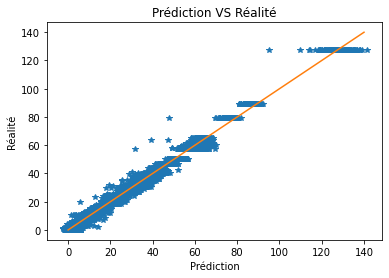

In [36]:
plt.plot(Y_train_predict, Y_train_ori, '*')
plt.plot(np.linspace(0, 140, 500), np.linspace(0, 140, 500))
plt.title("Prédiction VS Réalité")
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.show()

In [29]:
trainScore = math.sqrt(mean_squared_error(Y_train_ori, Y_train_predict[:,0]))
print('Train Score: %.5f RMSE' % (trainScore))

Train Score: 0.81023 RMSE


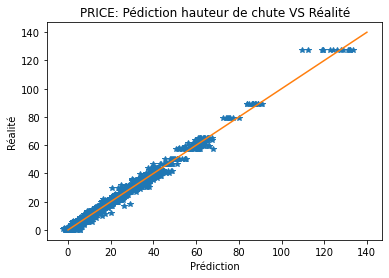

<Figure size 432x288 with 0 Axes>

In [38]:
plt.plot(Y_test_predict, Y_test, '*')
plt.plot(np.linspace(0, 140, 500), np.linspace(0, 140, 500))
plt.title("PRICE: Pédiction hauteur de chute VS Réalité")
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.show()
plt.savefig("prediction_reality.png")

In [39]:
#np.savetxt('Y_train_predict.out', Y_train_predict, delimiter=',')   # X is an array
#np.savetxt('y_train_real.out', Y_train_ori, delimiter=',')   # X is an array
# ... Sur la validation set 
Y_val_predict = model.predict([X_val_lstm, X_val2])
Y_val_predict = scalerY.inverse_transform(Y_val_predict)

#np.savetxt('Y_val_predict.out', Y_train_predict, delimiter=',')   # X is an array
#np.savetxt('y_val_real.out', Y_val, delimiter=',')   # X is an array

#testY_= scaler.inverse_transform([testY])
# Compute root mean squared error
#trainScore = math.sqrt(mean_squared_error(Y_train_ori, Y_train_predict[:,0]))
#print('Train Score: %.5f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(Y_val, Y_val_predict[:,0]))
print('Validation Score: %.5f RMSE' % (valScore))
print('Ecart type sur les données de validation: %.5f' %( np.std(Y_val)))
# ### 7. Test set

# In[ ]:
# ... Sur les données de  test 
Y_test_predict = model.predict([X_test_lstm, X_test2])
Y_test_predict = scalerY.inverse_transform(Y_test_predict)

#testY_= scaler.inverse_transform([testY])
#np.savetxt('Y_test_predict.out', Y_test_predict, delimiter=',')   # X is an array
#np.savetxt('y_test_real.out', Y_test, delimiter=',')   # X is an array
# Compute root mean squared error
testScore = math.sqrt(mean_squared_error(Y_test, Y_test_predict[:,0]))
print('Test Score: %.5f RMSE' % (testScore))
print('Ecart type sur les données de test: %.5f' % ( np.std(Y_test)))

Validation Score: 0.81693 RMSE
Ecart type sur les données de validation: 9.18212
Test Score: 0.79699 RMSE
Ecart type sur les données de test: 8.97620


In [40]:
print('Validation Score: %.5f RMSE' % (valScore))
print('Score de référence sur les données de validation: %.5f' %( np.std(Y_val)))
testScore = math.sqrt(mean_squared_error(Y_test, Y_test_predict[:,0]))
print('Test Score: %.5f RMSE' % (testScore))
print('Score de référence sur les données de test: %.5f' % ( np.std(Y_test)))

Validation Score: 0.81693 RMSE
Score de référence sur les données de validation: 9.18212
Test Score: 0.79699 RMSE
Score de référence sur les données de test: 8.97620


In [ ]:
DATA_SPLIT_PCT = 0.2

timesteps =  5
n_features =  20

epochs = 100
batch = 32
lr = 0.0001

lstm_autoencoder = Sequential([
    # Encoder
    LSTM(8, activation='relu', input_shape=(timesteps, n_features), return_sequences=True),
    LSTM(4, activation='relu', return_sequences=False),
    RepeatVector(timesteps),

    # Decoder
    LSTM(4, activation='relu', return_sequences=True),
    LSTM(8, activation='relu', return_sequences=True)
    TimeDistributed(Dense(n_features)),
])

adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

for stock in stock_list:  # 500 stocks in stock_list
    lstm_autoencoder_history = lstm_autoencoder.fit(X_train_dict[ticker], X_train_dict[ticker], 
                                                    epochs=epochs, 
                                                    batch_size=batch, 
                                                    validation_data=(X_valid_dict[ticker], X_valid_dict[ticker]),
                                                    verbose=False).history

plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.show()